# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

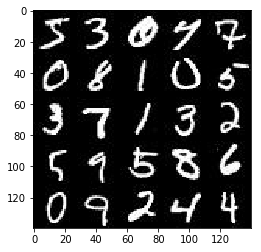

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

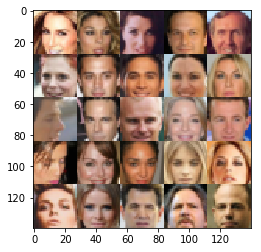

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0


/Users/amywu/anaconda2/envs/dlnd-tf-lab/lib/python3.5/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels])
    labels = tf.placeholder(tf.float32, [None, z_dim])
    learnRate = tf.placeholder(tf.float32, shape=[])
    return inputs, labels, learnRate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.1):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope("discriminator", reuse=reuse):
        #28*28*3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding="same")
        x1 = tf.maximum(x1*alpha, x1)
        #14*14*64
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding="same")
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(x2*alpha, x2)
        #7*7*128
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding="same")
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(x3*alpha, x3)
        #4*4*256
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [19]:
def generator(z, out_channel_dim, is_train=True, alpha=0.1):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    reuse = not(is_train)
    with tf.variable_scope('generator', reuse=reuse):
        
        x1 = tf.layers.dense(z, 7*7*256)
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha*x1, x1)
        #7*7*256
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding="same")
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha*x2, x2)
        #14*14*128
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding="same")
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha*x3, x3)
        #28*28*64
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding="same")
        #28*28*out_channel_dim
        out = tf.tanh(logits)
    return out



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [20]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [21]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith("discriminator")]
    g_vars = [var for var in t_vars if var.name.startswith("generator")]
    
    ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    d_ops = [op for op in ops if op.name.startswith("discriminator")]
    g_ops = [op for op in ops if op.name.startswith("generator")]
    
    with tf.control_dependencies(d_ops):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(g_ops):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [22]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [25]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, print_every=10, show_every=100):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                #run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z})
                
                if steps % print_every == 0: 
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                         "Discriminator Loss: {:.4f}...".format(train_loss_d),
                         "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % show_every == 0: 
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                    

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.1455... Generator Loss: 2.3628
Epoch 1/2... Discriminator Loss: 0.0417... Generator Loss: 3.5198
Epoch 1/2... Discriminator Loss: 0.0102... Generator Loss: 5.0432
Epoch 1/2... Discriminator Loss: 17.2403... Generator Loss: 17.1193
Epoch 1/2... Discriminator Loss: 0.4603... Generator Loss: 1.7396
Epoch 1/2... Discriminator Loss: 1.4198... Generator Loss: 2.7851
Epoch 1/2... Discriminator Loss: 1.2328... Generator Loss: 1.3128
Epoch 1/2... Discriminator Loss: 1.1579... Generator Loss: 1.2743
Epoch 1/2... Discriminator Loss: 1.5482... Generator Loss: 2.4354
Epoch 1/2... Discriminator Loss: 0.9716... Generator Loss: 0.8215


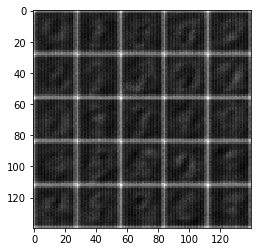

Epoch 1/2... Discriminator Loss: 0.9852... Generator Loss: 2.1764
Epoch 1/2... Discriminator Loss: 0.7522... Generator Loss: 1.3746
Epoch 1/2... Discriminator Loss: 0.5326... Generator Loss: 1.4818
Epoch 1/2... Discriminator Loss: 0.4637... Generator Loss: 1.8817
Epoch 1/2... Discriminator Loss: 0.3911... Generator Loss: 1.8294
Epoch 1/2... Discriminator Loss: 0.8819... Generator Loss: 4.1323
Epoch 1/2... Discriminator Loss: 0.2953... Generator Loss: 1.7642
Epoch 1/2... Discriminator Loss: 0.2550... Generator Loss: 2.0108
Epoch 1/2... Discriminator Loss: 0.1836... Generator Loss: 2.2431
Epoch 1/2... Discriminator Loss: 0.1022... Generator Loss: 2.9884


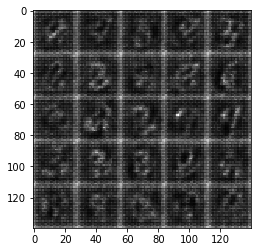

Epoch 1/2... Discriminator Loss: 0.1735... Generator Loss: 2.2014
Epoch 1/2... Discriminator Loss: 0.0988... Generator Loss: 2.7898
Epoch 1/2... Discriminator Loss: 0.0836... Generator Loss: 2.9278
Epoch 1/2... Discriminator Loss: 0.0725... Generator Loss: 3.0685
Epoch 1/2... Discriminator Loss: 0.0421... Generator Loss: 3.7007
Epoch 1/2... Discriminator Loss: 0.0159... Generator Loss: 4.8290
Epoch 1/2... Discriminator Loss: 0.0387... Generator Loss: 4.4854
Epoch 1/2... Discriminator Loss: 0.0252... Generator Loss: 4.3347
Epoch 1/2... Discriminator Loss: 0.0401... Generator Loss: 4.3453
Epoch 1/2... Discriminator Loss: 0.9193... Generator Loss: 0.7840


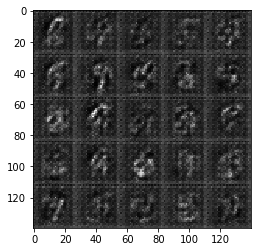

Epoch 1/2... Discriminator Loss: 1.1107... Generator Loss: 0.5025
Epoch 1/2... Discriminator Loss: 1.0867... Generator Loss: 0.4972
Epoch 1/2... Discriminator Loss: 0.9888... Generator Loss: 0.6367
Epoch 1/2... Discriminator Loss: 1.1265... Generator Loss: 0.5616
Epoch 1/2... Discriminator Loss: 0.1680... Generator Loss: 2.5626
Epoch 1/2... Discriminator Loss: 0.4180... Generator Loss: 1.4032
Epoch 1/2... Discriminator Loss: 0.2706... Generator Loss: 1.8279
Epoch 1/2... Discriminator Loss: 0.2485... Generator Loss: 1.8459
Epoch 1/2... Discriminator Loss: 0.4030... Generator Loss: 1.2884
Epoch 1/2... Discriminator Loss: 0.2965... Generator Loss: 1.6165


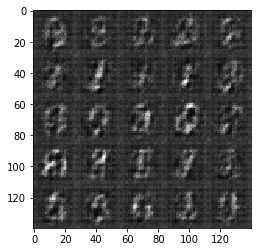

Epoch 1/2... Discriminator Loss: 2.8661... Generator Loss: 0.0806
Epoch 1/2... Discriminator Loss: 0.1456... Generator Loss: 2.6886
Epoch 1/2... Discriminator Loss: 0.4947... Generator Loss: 1.1021
Epoch 1/2... Discriminator Loss: 0.0601... Generator Loss: 4.1214
Epoch 1/2... Discriminator Loss: 0.4272... Generator Loss: 1.2891
Epoch 1/2... Discriminator Loss: 0.0422... Generator Loss: 5.1330
Epoch 1/2... Discriminator Loss: 0.8153... Generator Loss: 0.7466
Epoch 1/2... Discriminator Loss: 0.0928... Generator Loss: 6.3460
Epoch 1/2... Discriminator Loss: 0.2494... Generator Loss: 6.5077
Epoch 1/2... Discriminator Loss: 0.1463... Generator Loss: 2.4844


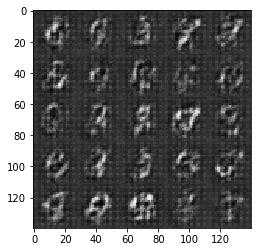

Epoch 1/2... Discriminator Loss: 1.4320... Generator Loss: 7.1382
Epoch 1/2... Discriminator Loss: 0.3998... Generator Loss: 1.4936
Epoch 1/2... Discriminator Loss: 0.1985... Generator Loss: 2.2644
Epoch 1/2... Discriminator Loss: 0.5319... Generator Loss: 1.0949
Epoch 1/2... Discriminator Loss: 0.0378... Generator Loss: 4.9658
Epoch 1/2... Discriminator Loss: 0.0606... Generator Loss: 4.0920
Epoch 1/2... Discriminator Loss: 0.0968... Generator Loss: 3.0086
Epoch 1/2... Discriminator Loss: 0.2108... Generator Loss: 1.9498
Epoch 1/2... Discriminator Loss: 0.1007... Generator Loss: 2.7074
Epoch 1/2... Discriminator Loss: 0.0885... Generator Loss: 3.0679


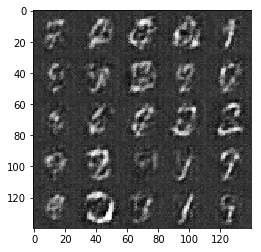

Epoch 1/2... Discriminator Loss: 0.0622... Generator Loss: 3.6140
Epoch 1/2... Discriminator Loss: 0.0163... Generator Loss: 5.7351
Epoch 1/2... Discriminator Loss: 0.5793... Generator Loss: 1.3492
Epoch 1/2... Discriminator Loss: 0.0985... Generator Loss: 3.5703
Epoch 1/2... Discriminator Loss: 1.3591... Generator Loss: 7.7340
Epoch 1/2... Discriminator Loss: 0.1607... Generator Loss: 2.7076
Epoch 1/2... Discriminator Loss: 0.2115... Generator Loss: 2.1528
Epoch 1/2... Discriminator Loss: 1.0691... Generator Loss: 6.3195
Epoch 1/2... Discriminator Loss: 0.0990... Generator Loss: 3.1545
Epoch 1/2... Discriminator Loss: 0.0199... Generator Loss: 5.6994


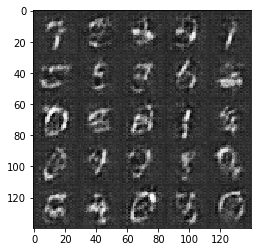

Epoch 1/2... Discriminator Loss: 0.0118... Generator Loss: 6.2962
Epoch 1/2... Discriminator Loss: 0.7855... Generator Loss: 1.6492
Epoch 1/2... Discriminator Loss: 0.2082... Generator Loss: 2.9598
Epoch 1/2... Discriminator Loss: 0.1123... Generator Loss: 3.7353
Epoch 1/2... Discriminator Loss: 0.1647... Generator Loss: 4.5299
Epoch 1/2... Discriminator Loss: 0.4387... Generator Loss: 1.2769
Epoch 1/2... Discriminator Loss: 0.1319... Generator Loss: 5.3733
Epoch 1/2... Discriminator Loss: 0.1105... Generator Loss: 4.3360
Epoch 1/2... Discriminator Loss: 0.0252... Generator Loss: 6.3712
Epoch 1/2... Discriminator Loss: 0.6138... Generator Loss: 1.5040


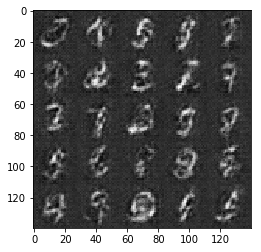

Epoch 1/2... Discriminator Loss: 0.3529... Generator Loss: 1.5195
Epoch 1/2... Discriminator Loss: 0.1162... Generator Loss: 2.6948
Epoch 1/2... Discriminator Loss: 0.0869... Generator Loss: 2.9122
Epoch 1/2... Discriminator Loss: 0.2348... Generator Loss: 1.9178
Epoch 1/2... Discriminator Loss: 0.0643... Generator Loss: 3.3709
Epoch 1/2... Discriminator Loss: 2.6275... Generator Loss: 0.1193
Epoch 1/2... Discriminator Loss: 0.5051... Generator Loss: 1.3500
Epoch 1/2... Discriminator Loss: 0.4245... Generator Loss: 1.5108
Epoch 1/2... Discriminator Loss: 0.4464... Generator Loss: 1.2182
Epoch 1/2... Discriminator Loss: 0.1364... Generator Loss: 2.5496


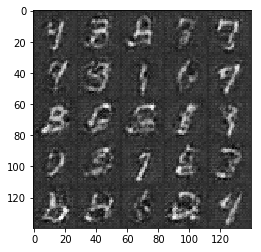

Epoch 1/2... Discriminator Loss: 0.1553... Generator Loss: 2.3577
Epoch 1/2... Discriminator Loss: 0.0830... Generator Loss: 3.2399
Epoch 1/2... Discriminator Loss: 0.2277... Generator Loss: 2.0817
Epoch 2/2... Discriminator Loss: 0.3022... Generator Loss: 1.5554
Epoch 2/2... Discriminator Loss: 0.0379... Generator Loss: 4.5697
Epoch 2/2... Discriminator Loss: 0.0373... Generator Loss: 4.5507
Epoch 2/2... Discriminator Loss: 0.0331... Generator Loss: 4.9967
Epoch 2/2... Discriminator Loss: 0.0158... Generator Loss: 7.1679
Epoch 2/2... Discriminator Loss: 0.0097... Generator Loss: 8.2955
Epoch 2/2... Discriminator Loss: 0.0158... Generator Loss: 5.8557


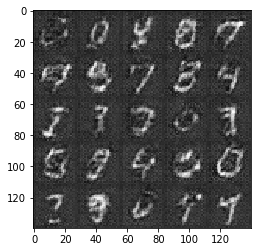

Epoch 2/2... Discriminator Loss: 3.5777... Generator Loss: 6.3540
Epoch 2/2... Discriminator Loss: 0.7444... Generator Loss: 1.0262
Epoch 2/2... Discriminator Loss: 0.7316... Generator Loss: 0.8593
Epoch 2/2... Discriminator Loss: 0.3401... Generator Loss: 1.6795
Epoch 2/2... Discriminator Loss: 0.0637... Generator Loss: 3.8746
Epoch 2/2... Discriminator Loss: 0.1503... Generator Loss: 3.3392
Epoch 2/2... Discriminator Loss: 0.0806... Generator Loss: 5.2132
Epoch 2/2... Discriminator Loss: 0.0779... Generator Loss: 3.2469
Epoch 2/2... Discriminator Loss: 0.0419... Generator Loss: 4.0382
Epoch 2/2... Discriminator Loss: 0.1062... Generator Loss: 3.1748


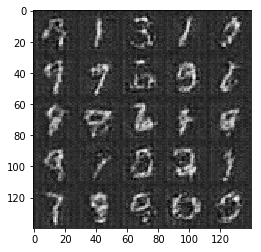

Epoch 2/2... Discriminator Loss: 0.0446... Generator Loss: 3.8494
Epoch 2/2... Discriminator Loss: 0.1061... Generator Loss: 2.9585
Epoch 2/2... Discriminator Loss: 0.3468... Generator Loss: 1.3856
Epoch 2/2... Discriminator Loss: 0.0420... Generator Loss: 5.1654
Epoch 2/2... Discriminator Loss: 0.0604... Generator Loss: 5.7586
Epoch 2/2... Discriminator Loss: 0.0386... Generator Loss: 6.0380
Epoch 2/2... Discriminator Loss: 0.0393... Generator Loss: 4.1364
Epoch 2/2... Discriminator Loss: 0.0360... Generator Loss: 4.0089
Epoch 2/2... Discriminator Loss: 0.0299... Generator Loss: 4.2897
Epoch 2/2... Discriminator Loss: 0.0096... Generator Loss: 6.1793


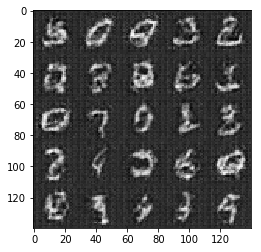

Epoch 2/2... Discriminator Loss: 2.1858... Generator Loss: 0.3148
Epoch 2/2... Discriminator Loss: 0.6088... Generator Loss: 1.0140
Epoch 2/2... Discriminator Loss: 0.6385... Generator Loss: 1.2236
Epoch 2/2... Discriminator Loss: 0.0963... Generator Loss: 3.4501
Epoch 2/2... Discriminator Loss: 0.1440... Generator Loss: 2.9797
Epoch 2/2... Discriminator Loss: 0.0394... Generator Loss: 5.8579
Epoch 2/2... Discriminator Loss: 0.1271... Generator Loss: 2.5763
Epoch 2/2... Discriminator Loss: 0.0466... Generator Loss: 4.7636
Epoch 2/2... Discriminator Loss: 0.0884... Generator Loss: 3.3157
Epoch 2/2... Discriminator Loss: 0.1270... Generator Loss: 2.6985


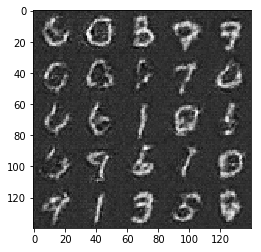

Epoch 2/2... Discriminator Loss: 0.0149... Generator Loss: 7.3701
Epoch 2/2... Discriminator Loss: 0.2356... Generator Loss: 1.8249
Epoch 2/2... Discriminator Loss: 0.0832... Generator Loss: 4.0142
Epoch 2/2... Discriminator Loss: 0.0981... Generator Loss: 2.8079
Epoch 2/2... Discriminator Loss: 0.0598... Generator Loss: 7.5597
Epoch 2/2... Discriminator Loss: 0.0974... Generator Loss: 2.8032
Epoch 2/2... Discriminator Loss: 0.1634... Generator Loss: 2.2495
Epoch 2/2... Discriminator Loss: 0.0132... Generator Loss: 6.6045
Epoch 2/2... Discriminator Loss: 0.0182... Generator Loss: 7.3347
Epoch 2/2... Discriminator Loss: 0.0202... Generator Loss: 6.0502


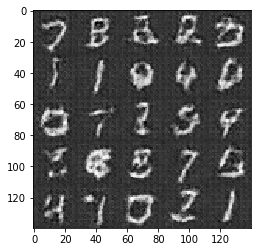

Epoch 2/2... Discriminator Loss: 0.0117... Generator Loss: 5.6914
Epoch 2/2... Discriminator Loss: 0.0847... Generator Loss: 4.4856
Epoch 2/2... Discriminator Loss: 0.0467... Generator Loss: 7.8532
Epoch 2/2... Discriminator Loss: 0.0138... Generator Loss: 7.6317
Epoch 2/2... Discriminator Loss: 5.7827... Generator Loss: 8.0633
Epoch 2/2... Discriminator Loss: 1.5413... Generator Loss: 2.0966
Epoch 2/2... Discriminator Loss: 1.1678... Generator Loss: 1.7515
Epoch 2/2... Discriminator Loss: 1.1241... Generator Loss: 0.6563
Epoch 2/2... Discriminator Loss: 1.2698... Generator Loss: 1.8824
Epoch 2/2... Discriminator Loss: 0.9309... Generator Loss: 1.7072


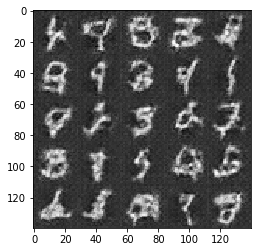

Epoch 2/2... Discriminator Loss: 0.8839... Generator Loss: 1.4049
Epoch 2/2... Discriminator Loss: 0.9025... Generator Loss: 2.1102
Epoch 2/2... Discriminator Loss: 0.7081... Generator Loss: 2.0602
Epoch 2/2... Discriminator Loss: 1.1049... Generator Loss: 0.5369
Epoch 2/2... Discriminator Loss: 0.9552... Generator Loss: 0.6840
Epoch 2/2... Discriminator Loss: 0.6491... Generator Loss: 0.9887
Epoch 2/2... Discriminator Loss: 0.6275... Generator Loss: 2.0525
Epoch 2/2... Discriminator Loss: 0.6089... Generator Loss: 1.9388
Epoch 2/2... Discriminator Loss: 1.1731... Generator Loss: 3.6880
Epoch 2/2... Discriminator Loss: 0.5165... Generator Loss: 1.3882


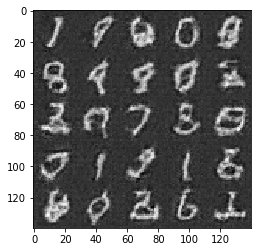

Epoch 2/2... Discriminator Loss: 0.5329... Generator Loss: 1.2352
Epoch 2/2... Discriminator Loss: 0.6311... Generator Loss: 0.9749
Epoch 2/2... Discriminator Loss: 0.6655... Generator Loss: 0.9329
Epoch 2/2... Discriminator Loss: 0.4787... Generator Loss: 1.1673
Epoch 2/2... Discriminator Loss: 0.5854... Generator Loss: 1.5225
Epoch 2/2... Discriminator Loss: 0.3815... Generator Loss: 1.4904
Epoch 2/2... Discriminator Loss: 0.2973... Generator Loss: 1.7399
Epoch 2/2... Discriminator Loss: 0.2359... Generator Loss: 2.0808
Epoch 2/2... Discriminator Loss: 0.2678... Generator Loss: 1.7708
Epoch 2/2... Discriminator Loss: 0.1275... Generator Loss: 2.7496


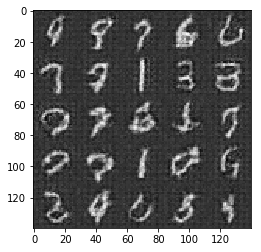

Epoch 2/2... Discriminator Loss: 2.8510... Generator Loss: 0.0803
Epoch 2/2... Discriminator Loss: 0.9411... Generator Loss: 0.7871
Epoch 2/2... Discriminator Loss: 0.5039... Generator Loss: 1.5872
Epoch 2/2... Discriminator Loss: 0.4197... Generator Loss: 1.4101
Epoch 2/2... Discriminator Loss: 0.2995... Generator Loss: 1.9505
Epoch 2/2... Discriminator Loss: 0.2184... Generator Loss: 2.2851
Epoch 2/2... Discriminator Loss: 0.1921... Generator Loss: 2.2560
Epoch 2/2... Discriminator Loss: 0.2032... Generator Loss: 2.2013
Epoch 2/2... Discriminator Loss: 0.0953... Generator Loss: 2.9584
Epoch 2/2... Discriminator Loss: 0.6153... Generator Loss: 1.0080


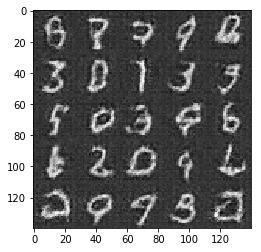

Epoch 2/2... Discriminator Loss: 0.3024... Generator Loss: 1.7223
Epoch 2/2... Discriminator Loss: 0.2198... Generator Loss: 2.1591
Epoch 2/2... Discriminator Loss: 0.4414... Generator Loss: 1.2708
Epoch 2/2... Discriminator Loss: 0.0794... Generator Loss: 5.1452
Epoch 2/2... Discriminator Loss: 0.5333... Generator Loss: 1.1245
Epoch 2/2... Discriminator Loss: 0.0786... Generator Loss: 4.6411
Epoch 2/2... Discriminator Loss: 0.1007... Generator Loss: 3.0187


In [28]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.1786... Generator Loss: 0.1594
Epoch 1/1... Discriminator Loss: 0.4618... Generator Loss: 1.3355
Epoch 1/1... Discriminator Loss: 2.6665... Generator Loss: 0.1344
Epoch 1/1... Discriminator Loss: 2.6943... Generator Loss: 0.1005
Epoch 1/1... Discriminator Loss: 1.1658... Generator Loss: 0.5598
Epoch 1/1... Discriminator Loss: 0.8408... Generator Loss: 0.7912
Epoch 1/1... Discriminator Loss: 0.5008... Generator Loss: 1.1794
Epoch 1/1... Discriminator Loss: 0.2603... Generator Loss: 1.9714
Epoch 1/1... Discriminator Loss: 0.0982... Generator Loss: 3.3885
Epoch 1/1... Discriminator Loss: 0.1377... Generator Loss: 2.5335


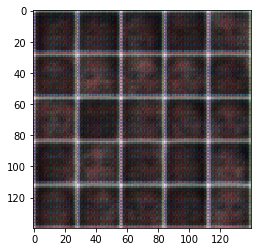

Epoch 1/1... Discriminator Loss: 0.1143... Generator Loss: 2.6870
Epoch 1/1... Discriminator Loss: 0.0581... Generator Loss: 3.4835
Epoch 1/1... Discriminator Loss: 0.0492... Generator Loss: 3.6307
Epoch 1/1... Discriminator Loss: 0.1535... Generator Loss: 2.2571
Epoch 1/1... Discriminator Loss: 0.3536... Generator Loss: 3.1910
Epoch 1/1... Discriminator Loss: 0.1654... Generator Loss: 2.4303
Epoch 1/1... Discriminator Loss: 0.2736... Generator Loss: 2.0985
Epoch 1/1... Discriminator Loss: 0.0518... Generator Loss: 4.2999
Epoch 1/1... Discriminator Loss: 0.0304... Generator Loss: 4.4831
Epoch 1/1... Discriminator Loss: 0.0299... Generator Loss: 4.1485


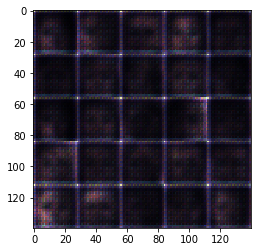

Epoch 1/1... Discriminator Loss: 0.5265... Generator Loss: 1.0152
Epoch 1/1... Discriminator Loss: 0.0053... Generator Loss: 6.6865
Epoch 1/1... Discriminator Loss: 0.0216... Generator Loss: 7.3938
Epoch 1/1... Discriminator Loss: 0.0072... Generator Loss: 13.4042
Epoch 1/1... Discriminator Loss: 0.8791... Generator Loss: 0.8831
Epoch 1/1... Discriminator Loss: 0.3643... Generator Loss: 1.3608
Epoch 1/1... Discriminator Loss: 2.3533... Generator Loss: 0.1397
Epoch 1/1... Discriminator Loss: 0.2793... Generator Loss: 7.5632
Epoch 1/1... Discriminator Loss: 0.9133... Generator Loss: 0.5952
Epoch 1/1... Discriminator Loss: 0.0284... Generator Loss: 4.9439


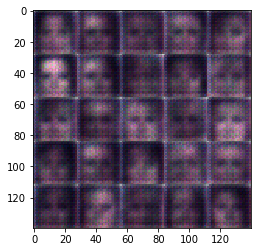

Epoch 1/1... Discriminator Loss: 0.0150... Generator Loss: 11.2423
Epoch 1/1... Discriminator Loss: 0.0066... Generator Loss: 6.4978
Epoch 1/1... Discriminator Loss: 0.0037... Generator Loss: 6.8292
Epoch 1/1... Discriminator Loss: 0.0557... Generator Loss: 9.3356
Epoch 1/1... Discriminator Loss: 0.4543... Generator Loss: 13.5439
Epoch 1/1... Discriminator Loss: 0.0212... Generator Loss: 9.0613
Epoch 1/1... Discriminator Loss: 0.0291... Generator Loss: 4.4885
Epoch 1/1... Discriminator Loss: 0.0371... Generator Loss: 3.5123
Epoch 1/1... Discriminator Loss: 0.0168... Generator Loss: 4.6860
Epoch 1/1... Discriminator Loss: 0.0243... Generator Loss: 9.2547


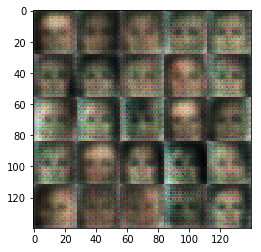

Epoch 1/1... Discriminator Loss: 0.0126... Generator Loss: 10.1360
Epoch 1/1... Discriminator Loss: 0.0062... Generator Loss: 10.1389
Epoch 1/1... Discriminator Loss: 0.0147... Generator Loss: 10.5984
Epoch 1/1... Discriminator Loss: 0.0099... Generator Loss: 5.5315
Epoch 1/1... Discriminator Loss: 0.2110... Generator Loss: 2.3258
Epoch 1/1... Discriminator Loss: 0.0829... Generator Loss: 3.0541
Epoch 1/1... Discriminator Loss: 0.0087... Generator Loss: 6.1748
Epoch 1/1... Discriminator Loss: 0.0120... Generator Loss: 5.3552
Epoch 1/1... Discriminator Loss: 0.0146... Generator Loss: 9.1548
Epoch 1/1... Discriminator Loss: 2.9261... Generator Loss: 11.0905


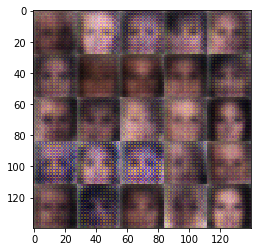

Epoch 1/1... Discriminator Loss: 0.7161... Generator Loss: 0.8329
Epoch 1/1... Discriminator Loss: 0.0293... Generator Loss: 9.6689
Epoch 1/1... Discriminator Loss: 0.0850... Generator Loss: 8.8083
Epoch 1/1... Discriminator Loss: 0.0515... Generator Loss: 4.0957
Epoch 1/1... Discriminator Loss: 0.0814... Generator Loss: 3.1099
Epoch 1/1... Discriminator Loss: 0.0112... Generator Loss: 7.1229
Epoch 1/1... Discriminator Loss: 0.0060... Generator Loss: 6.1139
Epoch 1/1... Discriminator Loss: 0.0320... Generator Loss: 8.1678
Epoch 1/1... Discriminator Loss: 0.0214... Generator Loss: 4.9370
Epoch 1/1... Discriminator Loss: 0.0122... Generator Loss: 7.5689


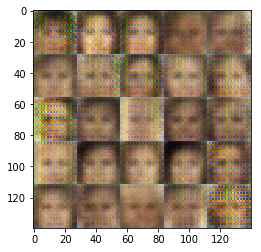

Epoch 1/1... Discriminator Loss: 0.2474... Generator Loss: 2.0620
Epoch 1/1... Discriminator Loss: 1.7161... Generator Loss: 0.2528
Epoch 1/1... Discriminator Loss: 0.0389... Generator Loss: 7.4190
Epoch 1/1... Discriminator Loss: 0.0208... Generator Loss: 5.2078
Epoch 1/1... Discriminator Loss: 0.0498... Generator Loss: 3.7529
Epoch 1/1... Discriminator Loss: 0.0067... Generator Loss: 8.2280
Epoch 1/1... Discriminator Loss: 0.6543... Generator Loss: 0.8818
Epoch 1/1... Discriminator Loss: 0.0626... Generator Loss: 5.0360
Epoch 1/1... Discriminator Loss: 0.0126... Generator Loss: 6.0718
Epoch 1/1... Discriminator Loss: 0.1004... Generator Loss: 2.6775


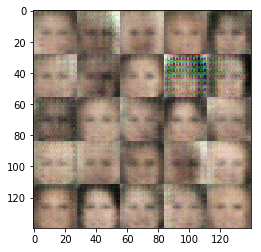

Epoch 1/1... Discriminator Loss: 0.0295... Generator Loss: 9.5131
Epoch 1/1... Discriminator Loss: 0.0077... Generator Loss: 7.1032
Epoch 1/1... Discriminator Loss: 0.0097... Generator Loss: 5.6650
Epoch 1/1... Discriminator Loss: 0.0086... Generator Loss: 5.6410
Epoch 1/1... Discriminator Loss: 0.3884... Generator Loss: 1.2805
Epoch 1/1... Discriminator Loss: 6.7193... Generator Loss: 0.0037
Epoch 1/1... Discriminator Loss: 0.0407... Generator Loss: 6.6090
Epoch 1/1... Discriminator Loss: 0.2815... Generator Loss: 1.6846
Epoch 1/1... Discriminator Loss: 0.0196... Generator Loss: 5.5671
Epoch 1/1... Discriminator Loss: 0.0418... Generator Loss: 6.4899


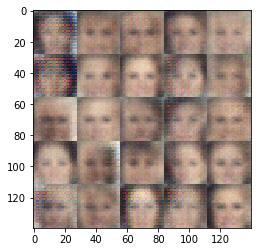

Epoch 1/1... Discriminator Loss: 0.1157... Generator Loss: 2.5391
Epoch 1/1... Discriminator Loss: 3.5978... Generator Loss: 0.0387
Epoch 1/1... Discriminator Loss: 0.9168... Generator Loss: 0.6472
Epoch 1/1... Discriminator Loss: 0.1145... Generator Loss: 2.6668
Epoch 1/1... Discriminator Loss: 1.3281... Generator Loss: 0.4340
Epoch 1/1... Discriminator Loss: 0.0739... Generator Loss: 3.4023
Epoch 1/1... Discriminator Loss: 0.7301... Generator Loss: 8.1371
Epoch 1/1... Discriminator Loss: 0.0631... Generator Loss: 3.2306
Epoch 1/1... Discriminator Loss: 0.5747... Generator Loss: 4.1021
Epoch 1/1... Discriminator Loss: 3.1138... Generator Loss: 3.5316


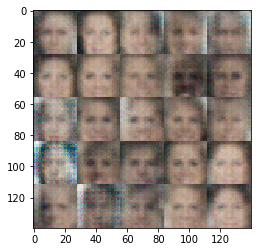

Epoch 1/1... Discriminator Loss: 0.7807... Generator Loss: 0.7596
Epoch 1/1... Discriminator Loss: 0.2437... Generator Loss: 2.4320
Epoch 1/1... Discriminator Loss: 0.8011... Generator Loss: 0.6950
Epoch 1/1... Discriminator Loss: 0.0297... Generator Loss: 6.2361
Epoch 1/1... Discriminator Loss: 0.0497... Generator Loss: 5.2190
Epoch 1/1... Discriminator Loss: 0.0124... Generator Loss: 5.4777
Epoch 1/1... Discriminator Loss: 0.1199... Generator Loss: 2.4228
Epoch 1/1... Discriminator Loss: 0.0463... Generator Loss: 3.5929
Epoch 1/1... Discriminator Loss: 0.0041... Generator Loss: 6.7711
Epoch 1/1... Discriminator Loss: 1.8367... Generator Loss: 7.3918


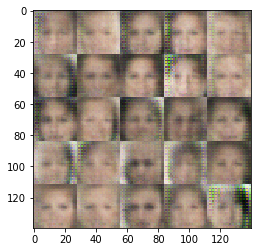

Epoch 1/1... Discriminator Loss: 0.9246... Generator Loss: 3.4364
Epoch 1/1... Discriminator Loss: 1.3474... Generator Loss: 0.3912
Epoch 1/1... Discriminator Loss: 1.1713... Generator Loss: 0.4780
Epoch 1/1... Discriminator Loss: 0.1340... Generator Loss: 5.8255
Epoch 1/1... Discriminator Loss: 0.6119... Generator Loss: 1.0906
Epoch 1/1... Discriminator Loss: 0.9085... Generator Loss: 0.7785
Epoch 1/1... Discriminator Loss: 0.0077... Generator Loss: 6.9406
Epoch 1/1... Discriminator Loss: 0.0140... Generator Loss: 9.4501
Epoch 1/1... Discriminator Loss: 0.3781... Generator Loss: 1.2954
Epoch 1/1... Discriminator Loss: 0.0268... Generator Loss: 6.6617


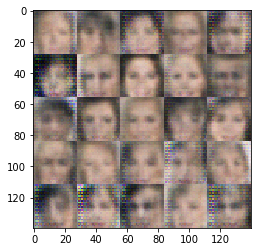

Epoch 1/1... Discriminator Loss: 1.0588... Generator Loss: 0.4738
Epoch 1/1... Discriminator Loss: 0.0361... Generator Loss: 5.7288
Epoch 1/1... Discriminator Loss: 0.2158... Generator Loss: 3.6323
Epoch 1/1... Discriminator Loss: 0.0169... Generator Loss: 6.0055
Epoch 1/1... Discriminator Loss: 0.4000... Generator Loss: 1.5827
Epoch 1/1... Discriminator Loss: 0.0237... Generator Loss: 4.0448
Epoch 1/1... Discriminator Loss: 0.4938... Generator Loss: 1.1492
Epoch 1/1... Discriminator Loss: 0.0163... Generator Loss: 6.0703
Epoch 1/1... Discriminator Loss: 0.0147... Generator Loss: 6.6827
Epoch 1/1... Discriminator Loss: 0.9853... Generator Loss: 5.8173


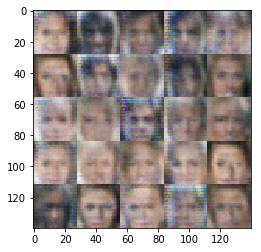

Epoch 1/1... Discriminator Loss: 0.0316... Generator Loss: 5.2420
Epoch 1/1... Discriminator Loss: 1.1282... Generator Loss: 0.4933
Epoch 1/1... Discriminator Loss: 0.8259... Generator Loss: 0.7596
Epoch 1/1... Discriminator Loss: 0.7069... Generator Loss: 0.8325
Epoch 1/1... Discriminator Loss: 3.8434... Generator Loss: 0.0265
Epoch 1/1... Discriminator Loss: 0.1100... Generator Loss: 3.1096
Epoch 1/1... Discriminator Loss: 0.0284... Generator Loss: 6.3717
Epoch 1/1... Discriminator Loss: 0.1503... Generator Loss: 3.2507
Epoch 1/1... Discriminator Loss: 1.2823... Generator Loss: 4.3633
Epoch 1/1... Discriminator Loss: 0.5814... Generator Loss: 1.0787


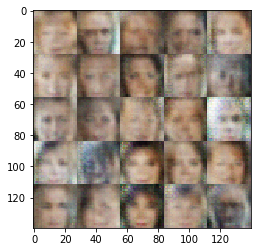

Epoch 1/1... Discriminator Loss: 0.2634... Generator Loss: 1.7190
Epoch 1/1... Discriminator Loss: 2.9472... Generator Loss: 9.6752
Epoch 1/1... Discriminator Loss: 2.0715... Generator Loss: 0.2087
Epoch 1/1... Discriminator Loss: 0.6205... Generator Loss: 0.9293
Epoch 1/1... Discriminator Loss: 0.0647... Generator Loss: 7.5113
Epoch 1/1... Discriminator Loss: 0.2321... Generator Loss: 7.9237
Epoch 1/1... Discriminator Loss: 0.0207... Generator Loss: 7.6795
Epoch 1/1... Discriminator Loss: 0.1256... Generator Loss: 2.9748
Epoch 1/1... Discriminator Loss: 0.0154... Generator Loss: 6.0219
Epoch 1/1... Discriminator Loss: 0.2034... Generator Loss: 6.1988


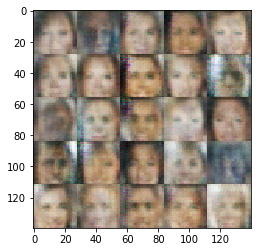

Epoch 1/1... Discriminator Loss: 0.0048... Generator Loss: 7.5365
Epoch 1/1... Discriminator Loss: 0.0142... Generator Loss: 7.9502
Epoch 1/1... Discriminator Loss: 0.0244... Generator Loss: 5.4343
Epoch 1/1... Discriminator Loss: 0.0261... Generator Loss: 10.2335
Epoch 1/1... Discriminator Loss: 0.0554... Generator Loss: 3.3132
Epoch 1/1... Discriminator Loss: 0.1654... Generator Loss: 7.8965
Epoch 1/1... Discriminator Loss: 1.5273... Generator Loss: 3.3333
Epoch 1/1... Discriminator Loss: 0.4042... Generator Loss: 1.5081
Epoch 1/1... Discriminator Loss: 1.1634... Generator Loss: 3.5087
Epoch 1/1... Discriminator Loss: 0.2636... Generator Loss: 5.9353


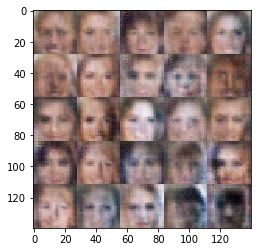

Epoch 1/1... Discriminator Loss: 0.1266... Generator Loss: 2.6010
Epoch 1/1... Discriminator Loss: 0.0336... Generator Loss: 4.2206
Epoch 1/1... Discriminator Loss: 0.0559... Generator Loss: 7.1489
Epoch 1/1... Discriminator Loss: 0.2539... Generator Loss: 1.7177
Epoch 1/1... Discriminator Loss: 0.0578... Generator Loss: 6.4170
Epoch 1/1... Discriminator Loss: 0.0152... Generator Loss: 7.3833
Epoch 1/1... Discriminator Loss: 0.0540... Generator Loss: 3.5961
Epoch 1/1... Discriminator Loss: 0.0859... Generator Loss: 3.4108
Epoch 1/1... Discriminator Loss: 0.1810... Generator Loss: 1.9738
Epoch 1/1... Discriminator Loss: 0.0181... Generator Loss: 5.2134


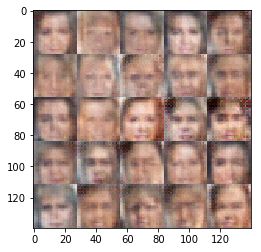

Epoch 1/1... Discriminator Loss: 0.4344... Generator Loss: 6.9008
Epoch 1/1... Discriminator Loss: 5.3072... Generator Loss: 2.3548
Epoch 1/1... Discriminator Loss: 0.0950... Generator Loss: 4.2236
Epoch 1/1... Discriminator Loss: 0.3183... Generator Loss: 1.5094
Epoch 1/1... Discriminator Loss: 0.2544... Generator Loss: 2.8552
Epoch 1/1... Discriminator Loss: 0.0504... Generator Loss: 7.5445
Epoch 1/1... Discriminator Loss: 0.0395... Generator Loss: 4.9354
Epoch 1/1... Discriminator Loss: 0.8762... Generator Loss: 0.7227
Epoch 1/1... Discriminator Loss: 0.7376... Generator Loss: 1.0874
Epoch 1/1... Discriminator Loss: 1.5557... Generator Loss: 0.3103


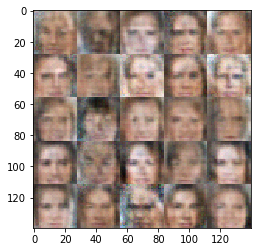

Epoch 1/1... Discriminator Loss: 0.5045... Generator Loss: 3.7424
Epoch 1/1... Discriminator Loss: 1.1047... Generator Loss: 0.6189
Epoch 1/1... Discriminator Loss: 0.1645... Generator Loss: 3.7955
Epoch 1/1... Discriminator Loss: 0.1763... Generator Loss: 5.1269
Epoch 1/1... Discriminator Loss: 1.3504... Generator Loss: 0.3575
Epoch 1/1... Discriminator Loss: 0.0928... Generator Loss: 7.6574
Epoch 1/1... Discriminator Loss: 0.2293... Generator Loss: 6.0165
Epoch 1/1... Discriminator Loss: 0.0277... Generator Loss: 5.0830
Epoch 1/1... Discriminator Loss: 0.1090... Generator Loss: 2.7964
Epoch 1/1... Discriminator Loss: 0.4944... Generator Loss: 1.1298


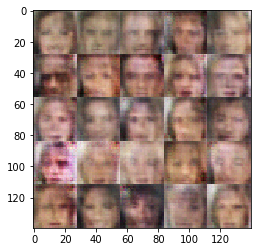

Epoch 1/1... Discriminator Loss: 0.9789... Generator Loss: 0.7501
Epoch 1/1... Discriminator Loss: 0.5467... Generator Loss: 1.0522
Epoch 1/1... Discriminator Loss: 0.0331... Generator Loss: 4.3504
Epoch 1/1... Discriminator Loss: 0.0288... Generator Loss: 5.9608
Epoch 1/1... Discriminator Loss: 0.2318... Generator Loss: 3.4511
Epoch 1/1... Discriminator Loss: 0.0969... Generator Loss: 3.0818
Epoch 1/1... Discriminator Loss: 0.4369... Generator Loss: 1.3174
Epoch 1/1... Discriminator Loss: 0.0258... Generator Loss: 6.4713
Epoch 1/1... Discriminator Loss: 0.0362... Generator Loss: 5.4243
Epoch 1/1... Discriminator Loss: 0.0334... Generator Loss: 4.4985


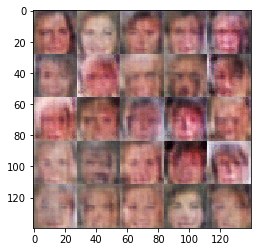

Epoch 1/1... Discriminator Loss: 0.0240... Generator Loss: 5.4011
Epoch 1/1... Discriminator Loss: 0.4989... Generator Loss: 1.3906
Epoch 1/1... Discriminator Loss: 2.6893... Generator Loss: 0.0835
Epoch 1/1... Discriminator Loss: 1.1723... Generator Loss: 3.8928
Epoch 1/1... Discriminator Loss: 0.1138... Generator Loss: 3.0814
Epoch 1/1... Discriminator Loss: 0.0314... Generator Loss: 10.2248
Epoch 1/1... Discriminator Loss: 0.2654... Generator Loss: 1.8550
Epoch 1/1... Discriminator Loss: 2.4364... Generator Loss: 4.7590
Epoch 1/1... Discriminator Loss: 0.8288... Generator Loss: 0.8413
Epoch 1/1... Discriminator Loss: 0.0778... Generator Loss: 4.0306


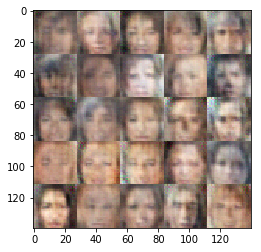

Epoch 1/1... Discriminator Loss: 0.1928... Generator Loss: 2.4116
Epoch 1/1... Discriminator Loss: 0.1415... Generator Loss: 2.6685
Epoch 1/1... Discriminator Loss: 0.0689... Generator Loss: 3.3681
Epoch 1/1... Discriminator Loss: 2.2242... Generator Loss: 4.1368
Epoch 1/1... Discriminator Loss: 0.5058... Generator Loss: 2.3955
Epoch 1/1... Discriminator Loss: 0.0705... Generator Loss: 3.6956
Epoch 1/1... Discriminator Loss: 0.3712... Generator Loss: 1.4604
Epoch 1/1... Discriminator Loss: 0.0454... Generator Loss: 4.8079
Epoch 1/1... Discriminator Loss: 0.7180... Generator Loss: 0.9875
Epoch 1/1... Discriminator Loss: 1.0499... Generator Loss: 6.8604


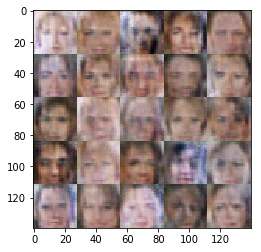

Epoch 1/1... Discriminator Loss: 4.0585... Generator Loss: 4.8736
Epoch 1/1... Discriminator Loss: 0.0803... Generator Loss: 6.0276
Epoch 1/1... Discriminator Loss: 0.4680... Generator Loss: 1.3228
Epoch 1/1... Discriminator Loss: 0.1512... Generator Loss: 2.5887
Epoch 1/1... Discriminator Loss: 0.0460... Generator Loss: 6.0465
Epoch 1/1... Discriminator Loss: 0.0348... Generator Loss: 8.6023
Epoch 1/1... Discriminator Loss: 3.1147... Generator Loss: 0.0751
Epoch 1/1... Discriminator Loss: 0.3071... Generator Loss: 1.8699
Epoch 1/1... Discriminator Loss: 0.0450... Generator Loss: 5.7196
Epoch 1/1... Discriminator Loss: 0.1682... Generator Loss: 4.0639


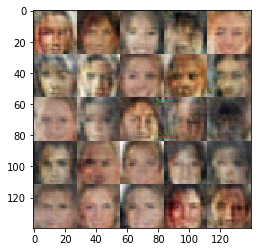

Epoch 1/1... Discriminator Loss: 0.1386... Generator Loss: 3.1164
Epoch 1/1... Discriminator Loss: 1.0018... Generator Loss: 0.5769
Epoch 1/1... Discriminator Loss: 0.0282... Generator Loss: 9.2014
Epoch 1/1... Discriminator Loss: 0.0550... Generator Loss: 4.6873
Epoch 1/1... Discriminator Loss: 0.5420... Generator Loss: 1.1628
Epoch 1/1... Discriminator Loss: 2.3899... Generator Loss: 5.1656
Epoch 1/1... Discriminator Loss: 0.8289... Generator Loss: 1.2819
Epoch 1/1... Discriminator Loss: 0.4269... Generator Loss: 2.6406
Epoch 1/1... Discriminator Loss: 0.4919... Generator Loss: 5.7772
Epoch 1/1... Discriminator Loss: 0.2464... Generator Loss: 1.9740


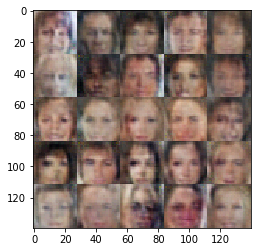

Epoch 1/1... Discriminator Loss: 0.0171... Generator Loss: 9.5959
Epoch 1/1... Discriminator Loss: 0.1310... Generator Loss: 3.8803
Epoch 1/1... Discriminator Loss: 0.6591... Generator Loss: 1.0960
Epoch 1/1... Discriminator Loss: 0.0558... Generator Loss: 4.5196
Epoch 1/1... Discriminator Loss: 0.0382... Generator Loss: 6.9577
Epoch 1/1... Discriminator Loss: 0.0345... Generator Loss: 8.9474
Epoch 1/1... Discriminator Loss: 0.8980... Generator Loss: 1.5278
Epoch 1/1... Discriminator Loss: 1.6139... Generator Loss: 0.3617
Epoch 1/1... Discriminator Loss: 0.3764... Generator Loss: 5.0203
Epoch 1/1... Discriminator Loss: 0.7040... Generator Loss: 1.3844


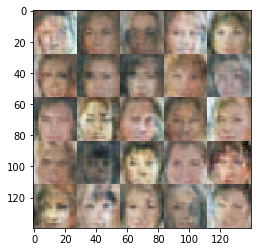

Epoch 1/1... Discriminator Loss: 0.4464... Generator Loss: 1.3791
Epoch 1/1... Discriminator Loss: 2.7290... Generator Loss: 3.8255
Epoch 1/1... Discriminator Loss: 0.4526... Generator Loss: 4.4572
Epoch 1/1... Discriminator Loss: 0.0558... Generator Loss: 5.9321
Epoch 1/1... Discriminator Loss: 0.1780... Generator Loss: 2.2740
Epoch 1/1... Discriminator Loss: 1.1870... Generator Loss: 2.6202
Epoch 1/1... Discriminator Loss: 0.1412... Generator Loss: 3.3578
Epoch 1/1... Discriminator Loss: 0.5641... Generator Loss: 1.1742
Epoch 1/1... Discriminator Loss: 0.3528... Generator Loss: 9.2555
Epoch 1/1... Discriminator Loss: 0.2422... Generator Loss: 2.9924


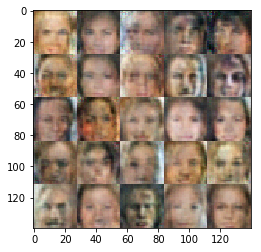

Epoch 1/1... Discriminator Loss: 0.8209... Generator Loss: 0.7549
Epoch 1/1... Discriminator Loss: 0.0864... Generator Loss: 3.6046
Epoch 1/1... Discriminator Loss: 0.0738... Generator Loss: 4.4532
Epoch 1/1... Discriminator Loss: 1.8176... Generator Loss: 0.2275
Epoch 1/1... Discriminator Loss: 0.2597... Generator Loss: 2.4593
Epoch 1/1... Discriminator Loss: 1.0497... Generator Loss: 0.5288
Epoch 1/1... Discriminator Loss: 1.6255... Generator Loss: 2.6882
Epoch 1/1... Discriminator Loss: 0.6477... Generator Loss: 1.0752
Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 3.8489
Epoch 1/1... Discriminator Loss: 0.4801... Generator Loss: 1.3797


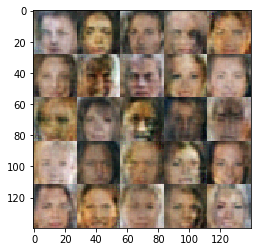

Epoch 1/1... Discriminator Loss: 0.7472... Generator Loss: 2.2686
Epoch 1/1... Discriminator Loss: 0.0486... Generator Loss: 5.2577
Epoch 1/1... Discriminator Loss: 0.3485... Generator Loss: 1.7595
Epoch 1/1... Discriminator Loss: 0.1932... Generator Loss: 6.7778
Epoch 1/1... Discriminator Loss: 0.3846... Generator Loss: 3.9026
Epoch 1/1... Discriminator Loss: 0.1313... Generator Loss: 2.8629
Epoch 1/1... Discriminator Loss: 1.4235... Generator Loss: 0.4572
Epoch 1/1... Discriminator Loss: 1.2609... Generator Loss: 0.4867
Epoch 1/1... Discriminator Loss: 0.9897... Generator Loss: 0.6769
Epoch 1/1... Discriminator Loss: 1.2028... Generator Loss: 0.4403


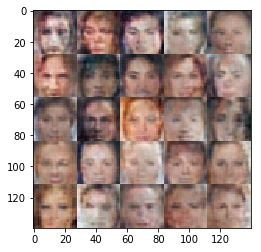

Epoch 1/1... Discriminator Loss: 2.4057... Generator Loss: 4.7830
Epoch 1/1... Discriminator Loss: 0.7518... Generator Loss: 0.8880
Epoch 1/1... Discriminator Loss: 0.4795... Generator Loss: 1.3838
Epoch 1/1... Discriminator Loss: 0.8039... Generator Loss: 0.9388
Epoch 1/1... Discriminator Loss: 0.3029... Generator Loss: 1.8480
Epoch 1/1... Discriminator Loss: 1.9971... Generator Loss: 0.2070
Epoch 1/1... Discriminator Loss: 0.1648... Generator Loss: 2.7238
Epoch 1/1... Discriminator Loss: 1.2731... Generator Loss: 0.4593
Epoch 1/1... Discriminator Loss: 0.7045... Generator Loss: 0.9465
Epoch 1/1... Discriminator Loss: 0.2467... Generator Loss: 2.3141


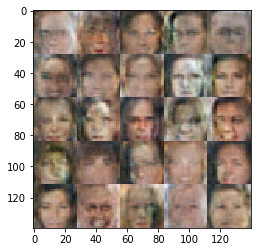

Epoch 1/1... Discriminator Loss: 0.2646... Generator Loss: 2.5407
Epoch 1/1... Discriminator Loss: 0.1942... Generator Loss: 2.2996
Epoch 1/1... Discriminator Loss: 0.1833... Generator Loss: 6.0352
Epoch 1/1... Discriminator Loss: 2.2154... Generator Loss: 3.0781
Epoch 1/1... Discriminator Loss: 1.5590... Generator Loss: 0.2871
Epoch 1/1... Discriminator Loss: 0.5574... Generator Loss: 3.6699
Epoch 1/1... Discriminator Loss: 0.3728... Generator Loss: 1.5139
Epoch 1/1... Discriminator Loss: 1.3265... Generator Loss: 0.4471
Epoch 1/1... Discriminator Loss: 0.2904... Generator Loss: 2.9551
Epoch 1/1... Discriminator Loss: 0.8923... Generator Loss: 0.6617


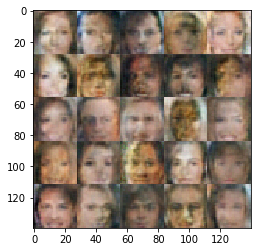

Epoch 1/1... Discriminator Loss: 0.8752... Generator Loss: 0.7296
Epoch 1/1... Discriminator Loss: 0.8361... Generator Loss: 1.1672
Epoch 1/1... Discriminator Loss: 0.1459... Generator Loss: 3.0640
Epoch 1/1... Discriminator Loss: 0.3738... Generator Loss: 1.6772
Epoch 1/1... Discriminator Loss: 0.1175... Generator Loss: 3.7587
Epoch 1/1... Discriminator Loss: 1.4229... Generator Loss: 0.3537
Epoch 1/1... Discriminator Loss: 0.1559... Generator Loss: 3.3889
Epoch 1/1... Discriminator Loss: 0.1594... Generator Loss: 3.1082
Epoch 1/1... Discriminator Loss: 1.4150... Generator Loss: 0.3230
Epoch 1/1... Discriminator Loss: 0.1383... Generator Loss: 3.0921


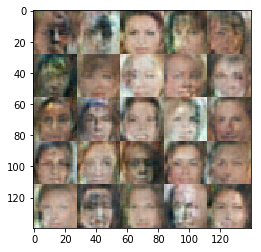

Epoch 1/1... Discriminator Loss: 0.9231... Generator Loss: 0.7208
Epoch 1/1... Discriminator Loss: 0.0784... Generator Loss: 5.7449
Epoch 1/1... Discriminator Loss: 0.0324... Generator Loss: 6.5564
Epoch 1/1... Discriminator Loss: 0.3257... Generator Loss: 1.9366
Epoch 1/1... Discriminator Loss: 0.5771... Generator Loss: 1.0405
Epoch 1/1... Discriminator Loss: 1.3213... Generator Loss: 4.5722
Epoch 1/1... Discriminator Loss: 0.9550... Generator Loss: 1.3715
Epoch 1/1... Discriminator Loss: 0.1942... Generator Loss: 3.3949
Epoch 1/1... Discriminator Loss: 1.0383... Generator Loss: 0.5373
Epoch 1/1... Discriminator Loss: 0.5659... Generator Loss: 1.1366


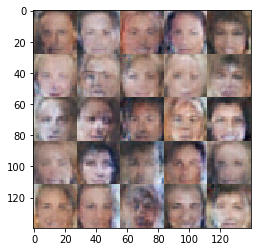

Epoch 1/1... Discriminator Loss: 0.6289... Generator Loss: 4.4942
Epoch 1/1... Discriminator Loss: 1.0211... Generator Loss: 0.5878
Epoch 1/1... Discriminator Loss: 0.8516... Generator Loss: 1.3299
Epoch 1/1... Discriminator Loss: 0.5284... Generator Loss: 1.2241
Epoch 1/1... Discriminator Loss: 0.1613... Generator Loss: 3.5844
Epoch 1/1... Discriminator Loss: 0.1352... Generator Loss: 4.8088
Epoch 1/1... Discriminator Loss: 0.6042... Generator Loss: 2.6353
Epoch 1/1... Discriminator Loss: 0.8550... Generator Loss: 0.7260
Epoch 1/1... Discriminator Loss: 0.7911... Generator Loss: 0.7595
Epoch 1/1... Discriminator Loss: 1.2503... Generator Loss: 3.3176


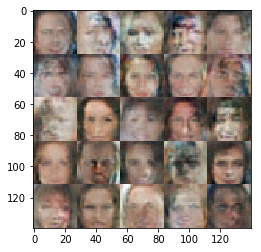

Epoch 1/1... Discriminator Loss: 0.5724... Generator Loss: 1.3221
Epoch 1/1... Discriminator Loss: 0.2310... Generator Loss: 2.3371
Epoch 1/1... Discriminator Loss: 0.0525... Generator Loss: 5.6824
Epoch 1/1... Discriminator Loss: 1.0925... Generator Loss: 1.5753
Epoch 1/1... Discriminator Loss: 0.1070... Generator Loss: 4.4351
Epoch 1/1... Discriminator Loss: 1.7339... Generator Loss: 0.2662
Epoch 1/1... Discriminator Loss: 0.7656... Generator Loss: 1.2284
Epoch 1/1... Discriminator Loss: 0.5156... Generator Loss: 1.2206
Epoch 1/1... Discriminator Loss: 0.8340... Generator Loss: 1.8569
Epoch 1/1... Discriminator Loss: 0.0514... Generator Loss: 6.1830


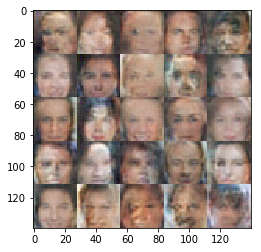

Epoch 1/1... Discriminator Loss: 0.2200... Generator Loss: 2.2791
Epoch 1/1... Discriminator Loss: 0.1253... Generator Loss: 3.0569
Epoch 1/1... Discriminator Loss: 0.5816... Generator Loss: 2.9878
Epoch 1/1... Discriminator Loss: 0.7441... Generator Loss: 0.8884
Epoch 1/1... Discriminator Loss: 1.1431... Generator Loss: 0.5105
Epoch 1/1... Discriminator Loss: 0.7727... Generator Loss: 0.9561
Epoch 1/1... Discriminator Loss: 2.6123... Generator Loss: 0.0992
Epoch 1/1... Discriminator Loss: 0.3241... Generator Loss: 1.8160
Epoch 1/1... Discriminator Loss: 1.1732... Generator Loss: 0.5106
Epoch 1/1... Discriminator Loss: 1.0253... Generator Loss: 0.6456


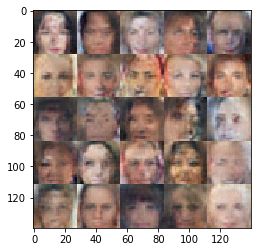

Epoch 1/1... Discriminator Loss: 0.3538... Generator Loss: 1.8583
Epoch 1/1... Discriminator Loss: 0.4346... Generator Loss: 2.8471
Epoch 1/1... Discriminator Loss: 0.1251... Generator Loss: 5.3693
Epoch 1/1... Discriminator Loss: 0.7742... Generator Loss: 0.9971
Epoch 1/1... Discriminator Loss: 0.9899... Generator Loss: 0.7546
Epoch 1/1... Discriminator Loss: 2.4340... Generator Loss: 0.1102
Epoch 1/1... Discriminator Loss: 1.4970... Generator Loss: 0.3606
Epoch 1/1... Discriminator Loss: 0.5720... Generator Loss: 1.3466
Epoch 1/1... Discriminator Loss: 0.4484... Generator Loss: 2.6229
Epoch 1/1... Discriminator Loss: 0.8711... Generator Loss: 0.7705


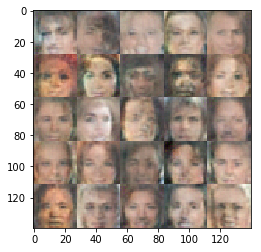

Epoch 1/1... Discriminator Loss: 0.4045... Generator Loss: 1.4961
Epoch 1/1... Discriminator Loss: 0.1985... Generator Loss: 2.4803
Epoch 1/1... Discriminator Loss: 0.0402... Generator Loss: 5.6315
Epoch 1/1... Discriminator Loss: 1.0305... Generator Loss: 0.5973
Epoch 1/1... Discriminator Loss: 0.1427... Generator Loss: 3.2128
Epoch 1/1... Discriminator Loss: 0.3442... Generator Loss: 1.7182
Epoch 1/1... Discriminator Loss: 1.4993... Generator Loss: 0.3207
Epoch 1/1... Discriminator Loss: 1.7363... Generator Loss: 0.2411
Epoch 1/1... Discriminator Loss: 0.8684... Generator Loss: 1.9830
Epoch 1/1... Discriminator Loss: 0.0578... Generator Loss: 4.6576


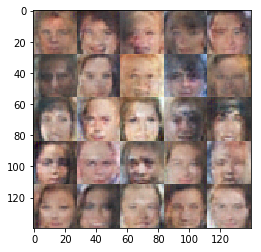

Epoch 1/1... Discriminator Loss: 0.4984... Generator Loss: 2.4764
Epoch 1/1... Discriminator Loss: 0.6638... Generator Loss: 1.4104
Epoch 1/1... Discriminator Loss: 0.6736... Generator Loss: 1.2090
Epoch 1/1... Discriminator Loss: 0.1295... Generator Loss: 3.2100
Epoch 1/1... Discriminator Loss: 0.0622... Generator Loss: 4.5577
Epoch 1/1... Discriminator Loss: 0.0983... Generator Loss: 3.4415
Epoch 1/1... Discriminator Loss: 0.0399... Generator Loss: 5.9218
Epoch 1/1... Discriminator Loss: 0.5450... Generator Loss: 1.4442
Epoch 1/1... Discriminator Loss: 0.9334... Generator Loss: 0.7868
Epoch 1/1... Discriminator Loss: 0.1784... Generator Loss: 3.1471


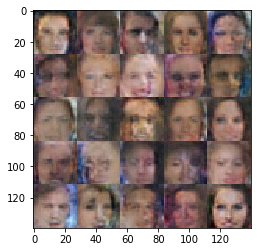

Epoch 1/1... Discriminator Loss: 0.7988... Generator Loss: 0.8633
Epoch 1/1... Discriminator Loss: 0.3428... Generator Loss: 2.0423
Epoch 1/1... Discriminator Loss: 0.3435... Generator Loss: 1.6237
Epoch 1/1... Discriminator Loss: 2.0112... Generator Loss: 0.1596
Epoch 1/1... Discriminator Loss: 0.0606... Generator Loss: 5.7994
Epoch 1/1... Discriminator Loss: 0.9701... Generator Loss: 1.6713
Epoch 1/1... Discriminator Loss: 1.2500... Generator Loss: 0.4469
Epoch 1/1... Discriminator Loss: 0.2931... Generator Loss: 1.9785
Epoch 1/1... Discriminator Loss: 0.4557... Generator Loss: 1.4554
Epoch 1/1... Discriminator Loss: 0.9752... Generator Loss: 0.5769


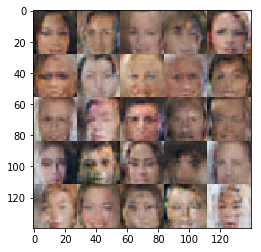

Epoch 1/1... Discriminator Loss: 0.3174... Generator Loss: 1.8477
Epoch 1/1... Discriminator Loss: 0.3161... Generator Loss: 5.2320
Epoch 1/1... Discriminator Loss: 0.8496... Generator Loss: 0.7319
Epoch 1/1... Discriminator Loss: 0.7132... Generator Loss: 0.9049
Epoch 1/1... Discriminator Loss: 0.0714... Generator Loss: 4.4226
Epoch 1/1... Discriminator Loss: 1.9232... Generator Loss: 0.3209
Epoch 1/1... Discriminator Loss: 2.5365... Generator Loss: 2.8907
Epoch 1/1... Discriminator Loss: 1.9305... Generator Loss: 0.2636
Epoch 1/1... Discriminator Loss: 0.9181... Generator Loss: 1.8678
Epoch 1/1... Discriminator Loss: 0.9767... Generator Loss: 0.6725


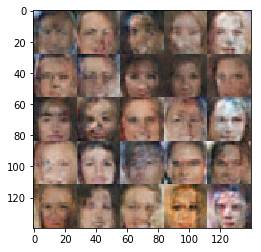

Epoch 1/1... Discriminator Loss: 0.4433... Generator Loss: 1.2653
Epoch 1/1... Discriminator Loss: 1.7627... Generator Loss: 0.2275
Epoch 1/1... Discriminator Loss: 0.5546... Generator Loss: 1.3218
Epoch 1/1... Discriminator Loss: 0.9428... Generator Loss: 0.7073
Epoch 1/1... Discriminator Loss: 0.0468... Generator Loss: 4.8150
Epoch 1/1... Discriminator Loss: 1.5748... Generator Loss: 0.3769
Epoch 1/1... Discriminator Loss: 2.7884... Generator Loss: 3.6810
Epoch 1/1... Discriminator Loss: 1.4700... Generator Loss: 0.3634
Epoch 1/1... Discriminator Loss: 1.0124... Generator Loss: 0.6865
Epoch 1/1... Discriminator Loss: 0.6697... Generator Loss: 1.1674


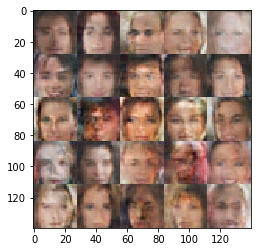

Epoch 1/1... Discriminator Loss: 1.2318... Generator Loss: 2.5681
Epoch 1/1... Discriminator Loss: 0.9792... Generator Loss: 0.6919
Epoch 1/1... Discriminator Loss: 0.0656... Generator Loss: 4.9649
Epoch 1/1... Discriminator Loss: 1.0421... Generator Loss: 0.5840
Epoch 1/1... Discriminator Loss: 0.1997... Generator Loss: 3.3920
Epoch 1/1... Discriminator Loss: 1.3615... Generator Loss: 0.4699
Epoch 1/1... Discriminator Loss: 1.3852... Generator Loss: 0.3320
Epoch 1/1... Discriminator Loss: 1.7711... Generator Loss: 0.2880
Epoch 1/1... Discriminator Loss: 0.0631... Generator Loss: 5.3947
Epoch 1/1... Discriminator Loss: 0.3828... Generator Loss: 2.1332


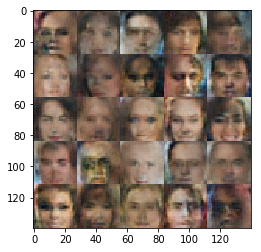

Epoch 1/1... Discriminator Loss: 2.4682... Generator Loss: 0.1180
Epoch 1/1... Discriminator Loss: 0.8752... Generator Loss: 0.6686
Epoch 1/1... Discriminator Loss: 0.5889... Generator Loss: 1.7339
Epoch 1/1... Discriminator Loss: 0.1060... Generator Loss: 3.6071
Epoch 1/1... Discriminator Loss: 0.5065... Generator Loss: 1.1429
Epoch 1/1... Discriminator Loss: 0.1826... Generator Loss: 6.4250
Epoch 1/1... Discriminator Loss: 1.1522... Generator Loss: 0.6238
Epoch 1/1... Discriminator Loss: 0.7447... Generator Loss: 1.9413
Epoch 1/1... Discriminator Loss: 0.1883... Generator Loss: 3.4953
Epoch 1/1... Discriminator Loss: 1.8068... Generator Loss: 0.2766


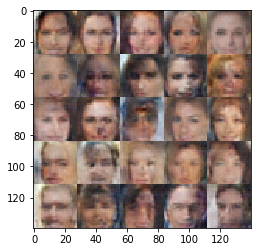

Epoch 1/1... Discriminator Loss: 0.9634... Generator Loss: 0.7645
Epoch 1/1... Discriminator Loss: 0.4070... Generator Loss: 2.3247
Epoch 1/1... Discriminator Loss: 0.3538... Generator Loss: 1.7078
Epoch 1/1... Discriminator Loss: 1.5879... Generator Loss: 0.3477
Epoch 1/1... Discriminator Loss: 0.9726... Generator Loss: 0.7287
Epoch 1/1... Discriminator Loss: 0.1430... Generator Loss: 2.7643
Epoch 1/1... Discriminator Loss: 0.2543... Generator Loss: 2.0557
Epoch 1/1... Discriminator Loss: 0.0489... Generator Loss: 4.8739
Epoch 1/1... Discriminator Loss: 0.0494... Generator Loss: 5.8935
Epoch 1/1... Discriminator Loss: 2.3628... Generator Loss: 0.1697


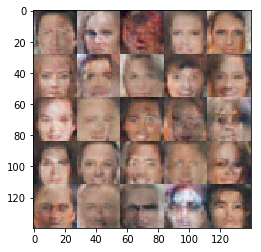

Epoch 1/1... Discriminator Loss: 1.2914... Generator Loss: 0.4299
Epoch 1/1... Discriminator Loss: 0.1146... Generator Loss: 3.4287
Epoch 1/1... Discriminator Loss: 0.6477... Generator Loss: 1.1390
Epoch 1/1... Discriminator Loss: 0.0432... Generator Loss: 4.6910
Epoch 1/1... Discriminator Loss: 1.3951... Generator Loss: 0.4430
Epoch 1/1... Discriminator Loss: 1.1478... Generator Loss: 0.5135
Epoch 1/1... Discriminator Loss: 1.2876... Generator Loss: 0.4585
Epoch 1/1... Discriminator Loss: 2.6428... Generator Loss: 0.1138
Epoch 1/1... Discriminator Loss: 1.8692... Generator Loss: 0.2430
Epoch 1/1... Discriminator Loss: 0.7215... Generator Loss: 1.0403


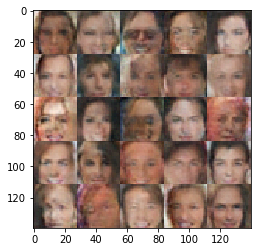

Epoch 1/1... Discriminator Loss: 1.3300... Generator Loss: 0.4321
Epoch 1/1... Discriminator Loss: 1.1728... Generator Loss: 4.6510
Epoch 1/1... Discriminator Loss: 1.0118... Generator Loss: 0.7034
Epoch 1/1... Discriminator Loss: 0.8094... Generator Loss: 0.8348
Epoch 1/1... Discriminator Loss: 2.7670... Generator Loss: 0.0807
Epoch 1/1... Discriminator Loss: 1.0238... Generator Loss: 0.6187
Epoch 1/1... Discriminator Loss: 1.1037... Generator Loss: 0.5277
Epoch 1/1... Discriminator Loss: 0.7414... Generator Loss: 1.0251
Epoch 1/1... Discriminator Loss: 1.4907... Generator Loss: 0.3361
Epoch 1/1... Discriminator Loss: 1.2793... Generator Loss: 2.3544


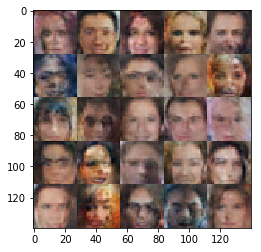

Epoch 1/1... Discriminator Loss: 0.1294... Generator Loss: 3.4944
Epoch 1/1... Discriminator Loss: 1.7574... Generator Loss: 0.2181
Epoch 1/1... Discriminator Loss: 1.5243... Generator Loss: 0.3198
Epoch 1/1... Discriminator Loss: 1.9707... Generator Loss: 3.7374
Epoch 1/1... Discriminator Loss: 0.7839... Generator Loss: 1.1153
Epoch 1/1... Discriminator Loss: 0.9498... Generator Loss: 1.4193
Epoch 1/1... Discriminator Loss: 0.3501... Generator Loss: 1.8239
Epoch 1/1... Discriminator Loss: 0.0787... Generator Loss: 3.7865
Epoch 1/1... Discriminator Loss: 0.1008... Generator Loss: 3.6803
Epoch 1/1... Discriminator Loss: 0.9269... Generator Loss: 1.2149


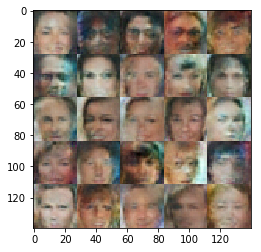

Epoch 1/1... Discriminator Loss: 0.6937... Generator Loss: 1.0175
Epoch 1/1... Discriminator Loss: 1.5382... Generator Loss: 0.3101
Epoch 1/1... Discriminator Loss: 0.9487... Generator Loss: 0.6418
Epoch 1/1... Discriminator Loss: 0.8908... Generator Loss: 0.9124
Epoch 1/1... Discriminator Loss: 0.1246... Generator Loss: 3.4635
Epoch 1/1... Discriminator Loss: 0.3967... Generator Loss: 1.5998
Epoch 1/1... Discriminator Loss: 1.3106... Generator Loss: 0.4725
Epoch 1/1... Discriminator Loss: 1.7278... Generator Loss: 0.2329
Epoch 1/1... Discriminator Loss: 0.4476... Generator Loss: 1.6328
Epoch 1/1... Discriminator Loss: 0.7302... Generator Loss: 0.9095


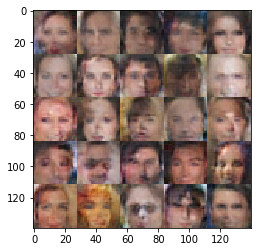

Epoch 1/1... Discriminator Loss: 0.4958... Generator Loss: 1.3418
Epoch 1/1... Discriminator Loss: 0.2486... Generator Loss: 2.4753
Epoch 1/1... Discriminator Loss: 0.6413... Generator Loss: 1.0459
Epoch 1/1... Discriminator Loss: 0.6675... Generator Loss: 1.5101
Epoch 1/1... Discriminator Loss: 0.8047... Generator Loss: 0.8452
Epoch 1/1... Discriminator Loss: 1.2915... Generator Loss: 0.4224
Epoch 1/1... Discriminator Loss: 0.2273... Generator Loss: 2.6612
Epoch 1/1... Discriminator Loss: 0.0659... Generator Loss: 4.8070
Epoch 1/1... Discriminator Loss: 0.1020... Generator Loss: 3.3563
Epoch 1/1... Discriminator Loss: 0.0571... Generator Loss: 4.6434


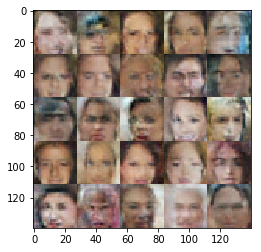

Epoch 1/1... Discriminator Loss: 0.9213... Generator Loss: 0.7434
Epoch 1/1... Discriminator Loss: 0.9820... Generator Loss: 3.1232
Epoch 1/1... Discriminator Loss: 1.0408... Generator Loss: 0.5284
Epoch 1/1... Discriminator Loss: 0.1876... Generator Loss: 2.4163
Epoch 1/1... Discriminator Loss: 0.0568... Generator Loss: 6.6556
Epoch 1/1... Discriminator Loss: 1.6489... Generator Loss: 0.2718
Epoch 1/1... Discriminator Loss: 0.0919... Generator Loss: 4.2700
Epoch 1/1... Discriminator Loss: 1.7162... Generator Loss: 4.3045
Epoch 1/1... Discriminator Loss: 0.2543... Generator Loss: 3.0534
Epoch 1/1... Discriminator Loss: 0.1804... Generator Loss: 4.1834


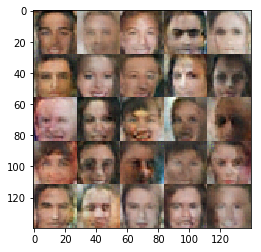

Epoch 1/1... Discriminator Loss: 0.6171... Generator Loss: 1.2043
Epoch 1/1... Discriminator Loss: 1.4636... Generator Loss: 4.3939
Epoch 1/1... Discriminator Loss: 1.0180... Generator Loss: 0.6241
Epoch 1/1... Discriminator Loss: 0.5082... Generator Loss: 1.2933
Epoch 1/1... Discriminator Loss: 1.2199... Generator Loss: 3.3373
Epoch 1/1... Discriminator Loss: 0.1900... Generator Loss: 2.7610
Epoch 1/1... Discriminator Loss: 0.2170... Generator Loss: 2.2782
Epoch 1/1... Discriminator Loss: 0.1142... Generator Loss: 3.3943
Epoch 1/1... Discriminator Loss: 1.1222... Generator Loss: 3.4343
Epoch 1/1... Discriminator Loss: 0.1901... Generator Loss: 3.2631


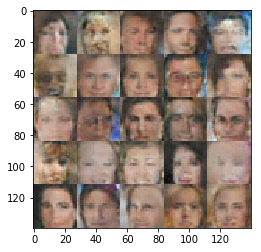

Epoch 1/1... Discriminator Loss: 0.3701... Generator Loss: 1.7516
Epoch 1/1... Discriminator Loss: 0.6237... Generator Loss: 1.4175
Epoch 1/1... Discriminator Loss: 1.7030... Generator Loss: 0.2470
Epoch 1/1... Discriminator Loss: 0.2405... Generator Loss: 2.3238
Epoch 1/1... Discriminator Loss: 1.9827... Generator Loss: 0.1750
Epoch 1/1... Discriminator Loss: 0.2557... Generator Loss: 2.7545
Epoch 1/1... Discriminator Loss: 0.9720... Generator Loss: 0.7335
Epoch 1/1... Discriminator Loss: 1.0829... Generator Loss: 0.5560
Epoch 1/1... Discriminator Loss: 2.0500... Generator Loss: 0.1893
Epoch 1/1... Discriminator Loss: 0.7481... Generator Loss: 0.8994


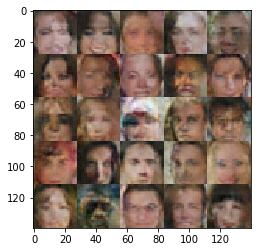

Epoch 1/1... Discriminator Loss: 0.3689... Generator Loss: 1.8952
Epoch 1/1... Discriminator Loss: 1.3192... Generator Loss: 2.9000
Epoch 1/1... Discriminator Loss: 1.3199... Generator Loss: 0.3748
Epoch 1/1... Discriminator Loss: 0.4258... Generator Loss: 1.6046
Epoch 1/1... Discriminator Loss: 2.8138... Generator Loss: 0.0919
Epoch 1/1... Discriminator Loss: 0.3157... Generator Loss: 2.6487
Epoch 1/1... Discriminator Loss: 0.5341... Generator Loss: 1.3888
Epoch 1/1... Discriminator Loss: 0.3502... Generator Loss: 1.7730
Epoch 1/1... Discriminator Loss: 0.1328... Generator Loss: 3.0721
Epoch 1/1... Discriminator Loss: 0.4926... Generator Loss: 1.3995


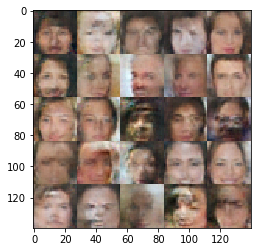

Epoch 1/1... Discriminator Loss: 1.4344... Generator Loss: 1.0150
Epoch 1/1... Discriminator Loss: 0.6976... Generator Loss: 1.0543
Epoch 1/1... Discriminator Loss: 0.2803... Generator Loss: 2.8787
Epoch 1/1... Discriminator Loss: 1.4620... Generator Loss: 3.3342
Epoch 1/1... Discriminator Loss: 0.7947... Generator Loss: 0.9750
Epoch 1/1... Discriminator Loss: 0.7589... Generator Loss: 2.7948
Epoch 1/1... Discriminator Loss: 0.4282... Generator Loss: 1.7263
Epoch 1/1... Discriminator Loss: 1.0146... Generator Loss: 0.7325
Epoch 1/1... Discriminator Loss: 1.7682... Generator Loss: 3.1386
Epoch 1/1... Discriminator Loss: 1.0269... Generator Loss: 0.6686


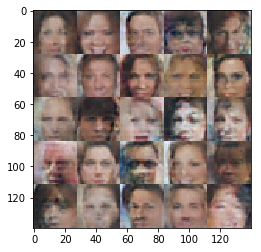

Epoch 1/1... Discriminator Loss: 2.5257... Generator Loss: 0.1503
Epoch 1/1... Discriminator Loss: 0.2430... Generator Loss: 2.7608
Epoch 1/1... Discriminator Loss: 0.6182... Generator Loss: 1.2885
Epoch 1/1... Discriminator Loss: 1.4630... Generator Loss: 0.3064
Epoch 1/1... Discriminator Loss: 0.9226... Generator Loss: 4.0739
Epoch 1/1... Discriminator Loss: 0.6963... Generator Loss: 1.0485
Epoch 1/1... Discriminator Loss: 1.0833... Generator Loss: 0.5219
Epoch 1/1... Discriminator Loss: 0.5458... Generator Loss: 2.6613
Epoch 1/1... Discriminator Loss: 0.5449... Generator Loss: 1.3550
Epoch 1/1... Discriminator Loss: 0.7058... Generator Loss: 1.3999


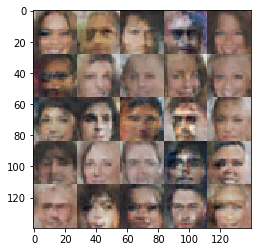

Epoch 1/1... Discriminator Loss: 0.7778... Generator Loss: 1.8708
Epoch 1/1... Discriminator Loss: 0.6734... Generator Loss: 1.0110
Epoch 1/1... Discriminator Loss: 0.6273... Generator Loss: 1.3302
Epoch 1/1... Discriminator Loss: 0.6451... Generator Loss: 1.3801
Epoch 1/1... Discriminator Loss: 2.4907... Generator Loss: 0.1138
Epoch 1/1... Discriminator Loss: 1.0364... Generator Loss: 1.7292
Epoch 1/1... Discriminator Loss: 0.3709... Generator Loss: 1.7641
Epoch 1/1... Discriminator Loss: 0.4581... Generator Loss: 1.6041
Epoch 1/1... Discriminator Loss: 2.8219... Generator Loss: 3.0658
Epoch 1/1... Discriminator Loss: 0.4215... Generator Loss: 1.4552


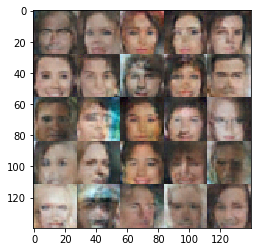

Epoch 1/1... Discriminator Loss: 1.2237... Generator Loss: 0.5716
Epoch 1/1... Discriminator Loss: 0.9021... Generator Loss: 1.0777
Epoch 1/1... Discriminator Loss: 1.3998... Generator Loss: 3.3103
Epoch 1/1... Discriminator Loss: 1.0033... Generator Loss: 0.6315
Epoch 1/1... Discriminator Loss: 2.3541... Generator Loss: 4.4121
Epoch 1/1... Discriminator Loss: 1.5137... Generator Loss: 3.7035
Epoch 1/1... Discriminator Loss: 0.3136... Generator Loss: 3.5555
Epoch 1/1... Discriminator Loss: 0.4582... Generator Loss: 1.7998
Epoch 1/1... Discriminator Loss: 1.7154... Generator Loss: 0.2480
Epoch 1/1... Discriminator Loss: 0.5244... Generator Loss: 1.3237


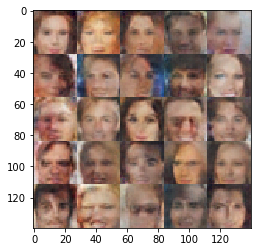

Epoch 1/1... Discriminator Loss: 1.7586... Generator Loss: 0.2476
Epoch 1/1... Discriminator Loss: 0.6961... Generator Loss: 1.2941
Epoch 1/1... Discriminator Loss: 0.2002... Generator Loss: 3.0021
Epoch 1/1... Discriminator Loss: 1.1632... Generator Loss: 0.5859
Epoch 1/1... Discriminator Loss: 0.1325... Generator Loss: 3.2878
Epoch 1/1... Discriminator Loss: 0.2132... Generator Loss: 3.4247
Epoch 1/1... Discriminator Loss: 0.7485... Generator Loss: 3.6673
Epoch 1/1... Discriminator Loss: 1.1736... Generator Loss: 0.5880
Epoch 1/1... Discriminator Loss: 1.2932... Generator Loss: 0.5405
Epoch 1/1... Discriminator Loss: 0.0659... Generator Loss: 6.4298


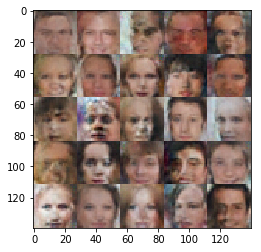

Epoch 1/1... Discriminator Loss: 1.9657... Generator Loss: 3.0109
Epoch 1/1... Discriminator Loss: 0.6297... Generator Loss: 1.1046
Epoch 1/1... Discriminator Loss: 2.5550... Generator Loss: 0.0969
Epoch 1/1... Discriminator Loss: 2.4120... Generator Loss: 0.1174
Epoch 1/1... Discriminator Loss: 0.5622... Generator Loss: 1.2702
Epoch 1/1... Discriminator Loss: 1.4361... Generator Loss: 0.3276
Epoch 1/1... Discriminator Loss: 0.6002... Generator Loss: 1.4324
Epoch 1/1... Discriminator Loss: 0.2235... Generator Loss: 7.7660
Epoch 1/1... Discriminator Loss: 3.0064... Generator Loss: 0.0678
Epoch 1/1... Discriminator Loss: 0.7368... Generator Loss: 1.2505


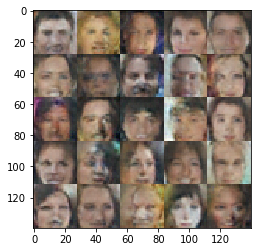

Epoch 1/1... Discriminator Loss: 0.0902... Generator Loss: 3.8285
Epoch 1/1... Discriminator Loss: 0.6200... Generator Loss: 1.2227
Epoch 1/1... Discriminator Loss: 1.8995... Generator Loss: 0.2754
Epoch 1/1... Discriminator Loss: 0.5919... Generator Loss: 1.0705
Epoch 1/1... Discriminator Loss: 0.3731... Generator Loss: 4.2392
Epoch 1/1... Discriminator Loss: 1.4174... Generator Loss: 0.3484
Epoch 1/1... Discriminator Loss: 0.2541... Generator Loss: 2.1867
Epoch 1/1... Discriminator Loss: 2.1845... Generator Loss: 0.1488
Epoch 1/1... Discriminator Loss: 0.5195... Generator Loss: 2.2526
Epoch 1/1... Discriminator Loss: 0.8270... Generator Loss: 0.7674


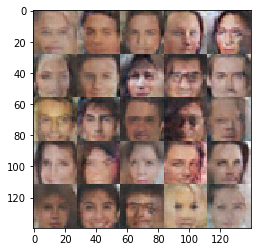

Epoch 1/1... Discriminator Loss: 0.9659... Generator Loss: 0.7652
Epoch 1/1... Discriminator Loss: 0.7183... Generator Loss: 0.9632
Epoch 1/1... Discriminator Loss: 0.2858... Generator Loss: 2.3699
Epoch 1/1... Discriminator Loss: 0.3051... Generator Loss: 2.0067
Epoch 1/1... Discriminator Loss: 1.3894... Generator Loss: 0.3782
Epoch 1/1... Discriminator Loss: 3.8157... Generator Loss: 0.0377
Epoch 1/1... Discriminator Loss: 1.4261... Generator Loss: 0.3409
Epoch 1/1... Discriminator Loss: 1.8519... Generator Loss: 0.2275
Epoch 1/1... Discriminator Loss: 0.2037... Generator Loss: 3.4047
Epoch 1/1... Discriminator Loss: 1.0310... Generator Loss: 2.6882


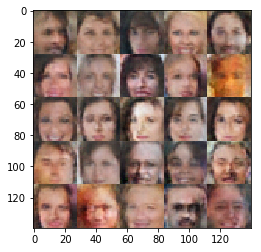

Epoch 1/1... Discriminator Loss: 0.9555... Generator Loss: 0.6455
Epoch 1/1... Discriminator Loss: 0.4278... Generator Loss: 1.6491
Epoch 1/1... Discriminator Loss: 1.8974... Generator Loss: 0.1892
Epoch 1/1... Discriminator Loss: 1.6992... Generator Loss: 0.4149
Epoch 1/1... Discriminator Loss: 0.7577... Generator Loss: 1.6154
Epoch 1/1... Discriminator Loss: 2.7765... Generator Loss: 0.0778
Epoch 1/1... Discriminator Loss: 0.4194... Generator Loss: 1.8103
Epoch 1/1... Discriminator Loss: 0.2540... Generator Loss: 2.1386
Epoch 1/1... Discriminator Loss: 0.1236... Generator Loss: 3.4046
Epoch 1/1... Discriminator Loss: 0.2338... Generator Loss: 2.3431


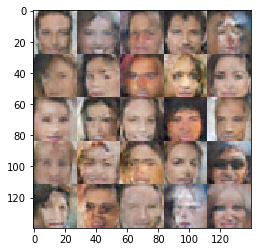

Epoch 1/1... Discriminator Loss: 1.7900... Generator Loss: 0.2242
Epoch 1/1... Discriminator Loss: 0.2399... Generator Loss: 2.5848
Epoch 1/1... Discriminator Loss: 0.3913... Generator Loss: 1.9710
Epoch 1/1... Discriminator Loss: 0.3606... Generator Loss: 1.8743
Epoch 1/1... Discriminator Loss: 0.0848... Generator Loss: 4.8071
Epoch 1/1... Discriminator Loss: 1.0217... Generator Loss: 0.5773
Epoch 1/1... Discriminator Loss: 0.8067... Generator Loss: 1.5356
Epoch 1/1... Discriminator Loss: 1.3558... Generator Loss: 0.4403
Epoch 1/1... Discriminator Loss: 0.7560... Generator Loss: 0.8825
Epoch 1/1... Discriminator Loss: 1.8540... Generator Loss: 0.2255


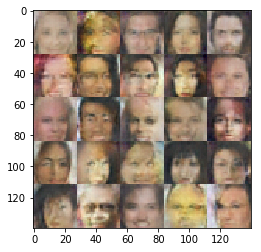

Epoch 1/1... Discriminator Loss: 2.4356... Generator Loss: 0.1005
Epoch 1/1... Discriminator Loss: 1.4401... Generator Loss: 0.3543
Epoch 1/1... Discriminator Loss: 1.3457... Generator Loss: 0.3784
Epoch 1/1... Discriminator Loss: 0.4507... Generator Loss: 1.2773
Epoch 1/1... Discriminator Loss: 2.2195... Generator Loss: 0.1700
Epoch 1/1... Discriminator Loss: 0.7558... Generator Loss: 0.9776
Epoch 1/1... Discriminator Loss: 0.7772... Generator Loss: 1.8994
Epoch 1/1... Discriminator Loss: 0.2469... Generator Loss: 2.1789
Epoch 1/1... Discriminator Loss: 0.5025... Generator Loss: 1.5672
Epoch 1/1... Discriminator Loss: 0.5034... Generator Loss: 1.4059


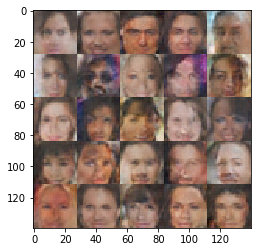

Epoch 1/1... Discriminator Loss: 1.8812... Generator Loss: 0.2364
Epoch 1/1... Discriminator Loss: 1.3561... Generator Loss: 3.4860
Epoch 1/1... Discriminator Loss: 1.0977... Generator Loss: 0.6281


In [31]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.